# Google drive mount

In [1]:
# 계정 드라이브와 마운트하기
# 모두 선택해서 동의해야 마운트가 오류없이 됩니다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 파일 가져오기

In [2]:
!ls /content/drive/MyDrive/Kaggle2

'Autocast, GrandScaler(Mixed Precision).gdoc'   project2_basecode.ipynb
 data.zip				        Untitled0.ipynb
'EMA(Model Exponential Moving Average).gdoc'   '제목 없는 문서.gdoc'


In [2]:
!unzip /content/drive/MyDrive/***/data.zip -d data

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/Kaggle02/train/Vehicle/033500.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033501.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033502.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033503.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033504.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033505.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033506.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033507.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033508.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033509.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033510.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033511.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033512.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033513.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033514.JPEG  
  inflating: data/Kaggle02/train/Vehicle/033515.JPEG  
  inflating: data/Kaggle02/train/Vehicle/0

# 파일 구조 확인

In [ ]:
!ls data/Kaggle02/train

Appliance  Electronic		Insect		   SportsEquipment  Weapon
Bird	   Fish			Mammal		   Structure
Building   Food			MusicalInstrument  Tool
Clothing   Furniture		Plant		   Utensil
Container  GeologicalFormation	Reptile		   Vehicle


In [ ]:
!ls data/Kaggle02/test/

000000.JPEG  000875.JPEG  001750.JPEG  002625.JPEG  003500.JPEG  004375.JPEG
000001.JPEG  000876.JPEG  001751.JPEG  002626.JPEG  003501.JPEG  004376.JPEG
000002.JPEG  000877.JPEG  001752.JPEG  002627.JPEG  003502.JPEG  004377.JPEG
000003.JPEG  000878.JPEG  001753.JPEG  002628.JPEG  003503.JPEG  004378.JPEG
000004.JPEG  000879.JPEG  001754.JPEG  002629.JPEG  003504.JPEG  004379.JPEG
000005.JPEG  000880.JPEG  001755.JPEG  002630.JPEG  003505.JPEG  004380.JPEG
000006.JPEG  000881.JPEG  001756.JPEG  002631.JPEG  003506.JPEG  004381.JPEG
000007.JPEG  000882.JPEG  001757.JPEG  002632.JPEG  003507.JPEG  004382.JPEG
000008.JPEG  000883.JPEG  001758.JPEG  002633.JPEG  003508.JPEG  004383.JPEG
000009.JPEG  000884.JPEG  001759.JPEG  002634.JPEG  003509.JPEG  004384.JPEG
000010.JPEG  000885.JPEG  001760.JPEG  002635.JPEG  003510.JPEG  004385.JPEG
000011.JPEG  000886.JPEG  001761.JPEG  002636.JPEG  003511.JPEG  004386.JPEG
000012.JPEG  000887.JPEG  001762.JPEG  002637.JPEG  003512.JPEG  004387.JPEG

In [3]:
import json

data = json.load(open("data/Kaggle02/class_name.json"))
data

{'Fish': 0,
 'Plant': 1,
 'Utensil': 2,
 'Insect': 3,
 'Appliance': 4,
 'Bird': 5,
 'Building': 6,
 'Clothing': 7,
 'Food': 8,
 'Structure': 9,
 'Container': 10,
 'Tool': 11,
 'SportsEquipment': 12,
 'Electronic': 13,
 'Reptile': 14,
 'Weapon': 15,
 'Mammal': 16,
 'MusicalInstrument': 17,
 'GeologicalFormation': 18,
 'Furniture': 19,
 'Vehicle': 20}

# DataLoader

압축푼 직후에는 파일적용이 되지 않아 FileNotFoundError 오류가 뜰 수 있습니다.

그러한 경우 약간의 대기 시간 이후 다시 실행하면 됩니다.

In [4]:
!pip install grad-cam tensorboard -q

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR,MultiStepLR
from torchvision.models import resnet18
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import copy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler
import timm

import torchvision.models as models
from sklearn.model_selection import train_test_split
from google.colab import files
from glob import glob
import random
import numpy as np
import torch
import torchvision.ops as ops
from torch.cuda.amp import autocast, GradScaler


seed = 0
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
#======================== Utils ==========================================
def tta_predict(model, images):

    # original
    logits1 = model(images)
    # horizontal flip
    images_flip = torch.flip(images, dims=[3])  # N,C,H,W
    logits2 = model(images_flip)
    # softmax avergage
    probs = (F.softmax(logits1, dim=1) +
             F.softmax(logits2, dim=1)) / 2
    return probs

class SoftTargetCrossEntropywithFL(nn.Module):
  def __init__(self, gamma=2.0, reduction="mean"):
    super().__init__()
    self.gamma = gamma
    self.reduction = reduction

  def forward(self, x, target):
      log_probs = F.log_softmax(x, dim=1)
      probs = torch.exp(log_probs)

      if target.dim() == 1:
        target = F.one_hot(target, num_classes = x.size(1)).float()

      loss = -target *((1-probs) ** self.gamma) * log_probs
      loss = loss.sum(dim=1)

      if self.reduction == "mean" :
        return loss.mean()
      elif self.reduction == "sum":
        return loss.sum()
      else:
        return loss

###visualization
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    axes[0].plot(history['train_losses'], label='Train Loss', linewidth=2.5, color='#3498db')
    axes[0].plot(history['val_losses'], label='Validation Loss', linewidth=2.5, color='#e74c3c')
    axes[0].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=13, fontweight='bold')
    axes[0].set_title('Training and Validation Loss', fontsize=15, fontweight='bold')
    axes[0].legend(fontsize=12, loc='upper right')
    axes[0].grid(True, alpha=0.3, linestyle='--')

    axes[1].plot(history['train_accs'], label='Train Accuracy', linewidth=2.5, color='#3498db')
    axes[1].plot(history['val_accs_ema'], label='Validation Accuracy', linewidth=2.5, color='#e74c3c')
    axes[1].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
    axes[1].set_title('Training and Validation Accuracy', fontsize=15, fontweight='bold')
    axes[1].legend(fontsize=12, loc='lower right')
    axes[1].grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

def download_model(model):
  torch.save(model.state_dict(), 'best_model.pth')
  files.download('best_model.pth')

def get_all_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Predicting'):
            inputs = inputs.to(device)

            with autocast():
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)

            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[0],
        cbar_kws={'label': 'Count'}
    )
    axes[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('True', fontsize=12, fontweight='bold')
    axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[1],
        cbar_kws={'label': 'Proportion'},
        vmin=0,
        vmax=1
    )
    axes[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('True', fontsize=12, fontweight='bold')
    axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f'{"Class":15s} {"Precision":>10s} {"Recall":>10s} {"F1-Score":>10s} {"Support":>10s}')
    print('-' * 70)

    for i, name in enumerate(class_names):
        precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
        recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        support = cm[i, :].sum()

        print(f'{name:15s} {precision:10.4f} {recall:10.4f} {f1:10.4f} {support:10d}')

    print('=' * 70)


class ModelEMA:
    """ Model Exponential Moving Average V2 from timm"""
    def __init__(self, model, decay=0.999, device=None):
        self.module = copy.deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device
        if self.device:
            self.module.to(device=self.device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)


In [6]:
""
############################Dataset##################################
#--- for custmoizing dataset
class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, train=True):
        self.train = train

        self.name2label = json.load(open(f"{data_path}/class_name.json"))


        if self.train:
            self.img_path = glob(f"{data_path}/train/*/*.JPEG")
            self.labels =  [self.name2label[d.split("/")[-2]] for d in self.img_path]
        else:
            self.img_path = glob(f"{data_path}/test/*.JPEG")

        self.transform = transform
        #for A100
        self.cached_images = [None] * len(self.img_path)

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, index):
        # 매번 읽어도 OS가 자주 읽는 파일은 RAM에 올려둡니다 (Page Cache)
        # 별도의 리스트 캐싱보다 이게 멀티프로세싱에서 더 빠릅니다.
        try:
            img = Image.open(self.img_path[index]).convert('RGB')
        except Exception as e:
            # 에러 처리 (빈 이미지 등)
            print(f"Error loading {self.img_path[index]}: {e}")
            return torch.zeros(3, 128, 128), 0

        if self.transform:
            img = self.transform(img)

        if self.train:
            return img, self.labels[index]
        else:
            return img, self.img_path[index].split("/")[-1]

#-- to apply transform after customizing dataset
class ApplyTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
#---- for switiching on/off the mixup/cutmix
class MixupCollate:
    def __init__(self, mixup_fn, switch_epoch):
        self.mixup_fn = mixup_fn
        self.switch_epoch = switch_epoch
        self.epoch = 0

    def set_epoch(self, epoch):
        self.epoch = epoch

    def __call__(self, batch):
        images, labels = zip(*batch)
        images = torch.stack(images)
        labels = torch.tensor(labels)

        if self.epoch < self.switch_epoch :
            return self.mixup_fn(images, labels)
        else:
            return images, labels

#-- make train_test set
def pre_process_data(transform,batch_size,is_train,train_val_split=0,collate_fn=None):
  data_path = "./data/Kaggle02/"

  # for A100
  loader_kwargs = {
        'batch_size': batch_size,
        'num_workers': 8,
        'pin_memory': True,
        'persistent_workers': True,
        'prefetch_factor': 4,       # [추가] 워커당 미리 로드할 배치 수 (대기 시간 단축)
        'drop_last': is_train,      # [추가] Train 시 마지막 자투리 배치는 버려서 사이즈 불일치 방지
      }
  #data augumentation
  # custmoizing data
  if is_train:
    train_dataset = MyDataset(data_path, train=is_train, transform=None)
    # split the traingdata to train and validation datasets
    if train_val_split is None:
        train_base = torch.utils.data.Subset(train_dataset, train_idx)
        val_base = 0

    else:
      train_idx, val_idx = train_test_split(
          np.arange(len(train_dataset)),
          test_size=train_val_split,
          stratify=train_dataset.labels,
          random_state=0
      )
      train_base = torch.utils.data.Subset(train_dataset, train_idx)
      val_base = torch.utils.data.Subset(train_dataset, val_idx)
    # apply transform
    train_data = ApplyTransform(train_base, transform=transform)
    val_data = ApplyTransform(val_base, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,collate_fn=collate_fn,**loader_kwargs)
    val_loader = torch.utils.data.DataLoader(val_data, shuffle=False,**loader_kwargs)
    return train_loader, val_loader
  else :
    test_dataset = MyDataset(data_path, train=is_train, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False,**loader_kwargs)
    return test_loader




In [7]:
class ConvNeXtTiny(nn.Module):
    def __init__(self, num_classes=21, drop_rate=0.3):
        super().__init__()

        self.backbone = timm.create_model(
            'convnext_tiny',
            pretrained=False,
            num_classes=0,
            drop_rate=drop_rate,
            drop_path_rate=0.1
        )

        # ConvNeXt-Tiny output dim = 768
        self.head = nn.Sequential(
            nn.LayerNorm(768),
            nn.Linear(768, 768),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(768, num_classes)
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        x = self.backbone(x)   # (B, 768)
        x = self.head(x)
        return x


In [8]:
#############Config#################
######dataset
mixup_collate_swiching_epoch = 130
val_train_split = 0.1
batch_size = 256
#train
num_epochs = 150
switching_epoch = 50
patience = 60 # early stopping
##### optimizer
lr = 4e-3 # learning rate
weight_decay = 0.15
#warm-up scheudler
warmup_epochs =8
start_factor=0.1
end_factor=1.0
min_lr = 1e-5

def save_checkpoint(model, ema, optimizer, scheduler, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'ema_state_dict': ema.module.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, path)




In [14]:

###data process
scaler = torch.amp.GradScaler('cuda') # Scaler 생성

train_transform = transforms.Compose([
    v2.Resize((192,192),antialias=True),
    v2.RandomHorizontalFlip(0.5),
    v2.RandAugment(num_ops=2, magnitude=7

                   ),
    v2.ColorJitter(0.2, 0.2, 0.2, 0.1),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485,0.456,0.406),
                 std=(0.229,0.224,0.225)),
    v2.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
])


test_transform =  transforms.Compose([
    v2.Resize((192, 192), antialias=True),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
      ])
collate = v2.RandomChoice([
    v2.CutMix(num_classes=21,alpha=0.2),
    v2.MixUp(num_classes=21, alpha=0.2)
    ])

mixup_collate = MixupCollate(
    mixup_fn=collate,
    switch_epoch=mixup_collate_swiching_epoch
)

train_loader,val_loader = pre_process_data(transform = train_transform,batch_size=batch_size,is_train=True,train_val_split= val_train_split,collate_fn=mixup_collate)
test_loader = pre_process_data(transform = test_transform,batch_size=batch_size,is_train=False)

##################training

torch.backends.cudnn.benchmark = True
model = ConvNeXtTiny()
model.to(device)
try:
    model = torch.compile(model) # 트레이닝 속도 20~30% 향상 가능
    print("Model compiled with torch.compile!")
except:
    pass
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_epochs
)

main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs - warmup_epochs, eta_min=min_lr
)

scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[warmup_epochs]
)

ema = ModelEMA(model, decay=0.999, device=device)

# for record
history = {}
train_losses, train_accs = [], []
val_losses = []
val_accs_model = []
val_accs_ema = []

best_val_acc = 0.0
epochs_no_improve = 0
best_model_state = None
try:
  for epoch in range(num_epochs):
      mixup_collate.set_epoch(epoch)
      model.train()

      total_loss = 0
      train_len = 0
      train_correct = 0

      if epoch < mixup_collate_swiching_epoch:
          criterion = SoftTargetCrossEntropywithFL(gamma=2.0)
      else:
          criterion = nn.CrossEntropyLoss(label_smoothing = 0.05)

      val_criterion = nn.CrossEntropyLoss()

      # --- Training Phase ---
      pbar = tqdm(enumerate(train_loader), total=len(train_loader))
      for i, (images, labels) in pbar:
          images, labels = images.to(device,non_blocking=True), labels.to(device,non_blocking=True)

          optimizer.zero_grad(set_to_none = True)
          with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()

          ema.update(model)

          pred = outputs.detach().argmax(dim=1)
          target_indices = labels.argmax(dim=1) if labels.dim() > 1 else labels
          train_correct += (pred == target_indices).sum().item()

          total_loss += loss.item() * images.size(0)
          train_len += images.size(0)

          pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / train_len:.4f}')

      train_losses.append(total_loss / train_len)
      train_accs.append(train_correct / train_len)

      # --- Validation Phase ---
      model.eval()
      ema.module.eval()

      v_loss_sum = 0.0
      v_correct_model = 0
      v_correct_ema = 0
      v_total = 0

      with torch.no_grad():
        with torch.amp.autocast('cuda'):
          for images, labels in val_loader:
              images, labels = images.to(device), labels.to(device)
              target = labels.argmax(dim=1) if labels.dim() > 1 else labels
              v_total += images.size(0)


              out_model = model(images)
              v_loss_sum += val_criterion(out_model, labels).item() * images.size(0)
              v_correct_model += (out_model.argmax(dim=1) == target).sum().item()


              out_ema = ema.module(images)
              v_correct_ema += (out_ema.argmax(dim=1) == target).sum().item()


      avg_v_loss = v_loss_sum / v_total
      acc_model = v_correct_model / v_total
      acc_ema = v_correct_ema / v_total

      val_losses.append(avg_v_loss)
      val_accs_model.append(acc_model)
      val_accs_ema.append(acc_ema)

      scheduler.step()

      if acc_ema > best_val_acc:
          best_val_acc = acc_ema
          best_model_state = copy.deepcopy(ema.module.state_dict())
          epochs_no_improve = 0
      else:
          epochs_no_improve += 1

      print(f'Val Loss: {avg_v_loss:.4f} | Model Acc: {acc_model*100:.2f}% | EMA Acc: {acc_ema*100:.2f}%')
      if (epoch + 1) % 5 == 0:
        torch.save(
            ema.module.state_dict(),
            "ema_last.pth"
        )

      if epochs_no_improve >= patience:
          print("Early stopping triggered.")
          break


  if best_model_state is not None:
      model.load_state_dict(best_model_state)

  history = {
      'train_losses': train_losses,
      'val_losses': val_losses,
      'train_accs': train_accs,
      'val_accs_model': val_accs_model,
      'val_accs_ema': val_accs_ema
  }


except KeyboardInterrupt:
  print("x")


finally:
    print("\n🛑 Training interrupted by user (Ctrl+C)")
    print(f"Saving model at epoch {epoch+1}...")

    save_checkpoint(
        model=model,
        ema=ema,
        optimizer=optimizer,
        scheduler=scheduler,
        epoch=epoch,
        path=f'checkpoint_interrupt_epoch_{epoch+1}.pth'
    )
    print("✅ Training finished (or interrupted).")


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Model compiled with torch.compile!


Epoch [1/150], Loss: 2.6884: 100%|██████████| 258/258 [03:28<00:00,  1.24it/s]


Val Loss: 2.8551 | Model Acc: 12.71% | EMA Acc: 8.40%


Epoch [2/150], Loss: 2.6257: 100%|██████████| 258/258 [01:53<00:00,  2.26it/s]


Val Loss: 2.7460 | Model Acc: 14.56% | EMA Acc: 11.98%


Epoch [3/150], Loss: 2.5745: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 2.6806 | Model Acc: 17.16% | EMA Acc: 13.13%


Epoch [4/150], Loss: 2.5279: 100%|██████████| 258/258 [01:53<00:00,  2.28it/s]


Val Loss: 2.5644 | Model Acc: 20.51% | EMA Acc: 15.56%


Epoch [5/150], Loss: 2.4502: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 2.4987 | Model Acc: 21.99% | EMA Acc: 17.54%


Epoch [6/150], Loss: 2.3851: 100%|██████████| 258/258 [01:53<00:00,  2.28it/s]


Val Loss: 2.5240 | Model Acc: 23.03% | EMA Acc: 19.29%


Epoch [7/150], Loss: 2.2925: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 2.3041 | Model Acc: 29.13% | EMA Acc: 21.15%


Epoch [8/150], Loss: 2.2629: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 2.2036 | Model Acc: 31.99% | EMA Acc: 23.28%


Epoch [9/150], Loss: 2.2049: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 2.1727 | Model Acc: 32.84% | EMA Acc: 25.81%


Epoch [10/150], Loss: 2.1994: 100%|██████████| 258/258 [01:53<00:00,  2.26it/s]


Val Loss: 2.1257 | Model Acc: 33.93% | EMA Acc: 28.00%


Epoch [11/150], Loss: 2.1907: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 2.0794 | Model Acc: 34.50% | EMA Acc: 29.58%


Epoch [12/150], Loss: 2.1303: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 2.0681 | Model Acc: 36.08% | EMA Acc: 31.70%


Epoch [13/150], Loss: 2.0781: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 2.1406 | Model Acc: 35.59% | EMA Acc: 33.68%


Epoch [14/150], Loss: 2.0539: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.9818 | Model Acc: 39.37% | EMA Acc: 35.13%


Epoch [15/150], Loss: 2.0331: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 2.0763 | Model Acc: 37.86% | EMA Acc: 36.76%


Epoch [16/150], Loss: 2.0453: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.8699 | Model Acc: 42.16% | EMA Acc: 38.21%


Epoch [17/150], Loss: 2.0171: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.8694 | Model Acc: 41.96% | EMA Acc: 39.65%


Epoch [18/150], Loss: 1.9660: 100%|██████████| 258/258 [01:55<00:00,  2.24it/s]


Val Loss: 1.9094 | Model Acc: 41.49% | EMA Acc: 40.78%


Epoch [19/150], Loss: 1.9193: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.7856 | Model Acc: 44.71% | EMA Acc: 42.51%


Epoch [20/150], Loss: 1.9160: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.7744 | Model Acc: 45.15% | EMA Acc: 43.78%


Epoch [21/150], Loss: 1.9184: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.7804 | Model Acc: 45.70% | EMA Acc: 45.09%


Epoch [22/150], Loss: 1.8878: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.6875 | Model Acc: 48.65% | EMA Acc: 46.51%


Epoch [23/150], Loss: 1.8251: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.7362 | Model Acc: 47.80% | EMA Acc: 47.91%


Epoch [24/150], Loss: 1.8415: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.6420 | Model Acc: 49.85% | EMA Acc: 49.20%


Epoch [25/150], Loss: 1.7865: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.6511 | Model Acc: 50.24% | EMA Acc: 50.89%


Epoch [26/150], Loss: 1.7819: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.6179 | Model Acc: 52.64% | EMA Acc: 52.27%


Epoch [27/150], Loss: 1.7676: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.6412 | Model Acc: 50.78% | EMA Acc: 53.56%


Epoch [28/150], Loss: 1.7303: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.6058 | Model Acc: 51.13% | EMA Acc: 55.08%


Epoch [29/150], Loss: 1.6875: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.6320 | Model Acc: 51.33% | EMA Acc: 56.11%


Epoch [30/150], Loss: 1.6892: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.5642 | Model Acc: 53.10% | EMA Acc: 57.13%


Epoch [31/150], Loss: 1.6701: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.4725 | Model Acc: 56.07% | EMA Acc: 58.47%


Epoch [32/150], Loss: 1.5941: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.5021 | Model Acc: 54.83% | EMA Acc: 59.24%


Epoch [33/150], Loss: 1.6554: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.3928 | Model Acc: 58.18% | EMA Acc: 59.88%


Epoch [34/150], Loss: 1.5926: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.4384 | Model Acc: 57.45% | EMA Acc: 61.20%


Epoch [35/150], Loss: 1.6025: 100%|██████████| 258/258 [01:53<00:00,  2.26it/s]


Val Loss: 1.3718 | Model Acc: 59.51% | EMA Acc: 61.84%


Epoch [36/150], Loss: 1.6038: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.3737 | Model Acc: 59.40% | EMA Acc: 62.75%


Epoch [37/150], Loss: 1.5984: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.4477 | Model Acc: 59.28% | EMA Acc: 63.39%


Epoch [38/150], Loss: 1.5423: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.3183 | Model Acc: 60.81% | EMA Acc: 64.33%


Epoch [39/150], Loss: 1.5422: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.4201 | Model Acc: 59.01% | EMA Acc: 64.82%


Epoch [40/150], Loss: 1.5340: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.4215 | Model Acc: 59.29% | EMA Acc: 65.53%


Epoch [41/150], Loss: 1.5517: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.3703 | Model Acc: 60.44% | EMA Acc: 66.16%


Epoch [42/150], Loss: 1.5288: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.3223 | Model Acc: 62.61% | EMA Acc: 66.59%


Epoch [43/150], Loss: 1.4959: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.3544 | Model Acc: 60.46% | EMA Acc: 67.19%


Epoch [44/150], Loss: 1.5524: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.3078 | Model Acc: 62.75% | EMA Acc: 67.77%


Epoch [45/150], Loss: 1.4963: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.3084 | Model Acc: 61.97% | EMA Acc: 68.50%


Epoch [46/150], Loss: 1.4312: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.3094 | Model Acc: 61.94% | EMA Acc: 68.99%


Epoch [47/150], Loss: 1.4158: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.2567 | Model Acc: 62.17% | EMA Acc: 69.34%


Epoch [48/150], Loss: 1.4636: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.3040 | Model Acc: 63.02% | EMA Acc: 69.84%


Epoch [49/150], Loss: 1.4211: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.2499 | Model Acc: 63.98% | EMA Acc: 70.26%


Epoch [50/150], Loss: 1.4362: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.2766 | Model Acc: 64.33% | EMA Acc: 70.51%


Epoch [51/150], Loss: 1.4370: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.2772 | Model Acc: 63.62% | EMA Acc: 70.86%


Epoch [52/150], Loss: 1.3758: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.2175 | Model Acc: 64.19% | EMA Acc: 71.43%


Epoch [53/150], Loss: 1.3574: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.2029 | Model Acc: 65.36% | EMA Acc: 71.88%


Epoch [54/150], Loss: 1.3666: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.2469 | Model Acc: 65.47% | EMA Acc: 72.22%


Epoch [55/150], Loss: 1.3464: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.2559 | Model Acc: 64.63% | EMA Acc: 72.50%


Epoch [56/150], Loss: 1.3522: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.2061 | Model Acc: 65.71% | EMA Acc: 72.59%


Epoch [57/150], Loss: 1.3197: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.1199 | Model Acc: 67.35% | EMA Acc: 72.82%


Epoch [58/150], Loss: 1.3547: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.1509 | Model Acc: 67.75% | EMA Acc: 73.09%


Epoch [59/150], Loss: 1.3050: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.1567 | Model Acc: 66.02% | EMA Acc: 73.09%


Epoch [60/150], Loss: 1.3425: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.3034 | Model Acc: 62.89% | EMA Acc: 73.42%


Epoch [61/150], Loss: 1.3384: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.1391 | Model Acc: 67.17% | EMA Acc: 73.73%


Epoch [62/150], Loss: 1.3304: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.1395 | Model Acc: 68.12% | EMA Acc: 74.25%


Epoch [63/150], Loss: 1.2538: 100%|██████████| 258/258 [01:54<00:00,  2.24it/s]


Val Loss: 1.1199 | Model Acc: 68.23% | EMA Acc: 74.41%


Epoch [64/150], Loss: 1.3000: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.1716 | Model Acc: 67.79% | EMA Acc: 74.64%


Epoch [65/150], Loss: 1.2504: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.0720 | Model Acc: 69.00% | EMA Acc: 74.73%


Epoch [66/150], Loss: 1.2503: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.1565 | Model Acc: 67.24% | EMA Acc: 75.18%


Epoch [67/150], Loss: 1.2999: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.1665 | Model Acc: 68.04% | EMA Acc: 75.36%


Epoch [68/150], Loss: 1.2996: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.1532 | Model Acc: 68.11% | EMA Acc: 75.52%


Epoch [69/150], Loss: 1.2294: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.1125 | Model Acc: 69.70% | EMA Acc: 75.46%


Epoch [70/150], Loss: 1.2485: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.1150 | Model Acc: 69.04% | EMA Acc: 75.93%


Epoch [71/150], Loss: 1.2239: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.0909 | Model Acc: 69.46% | EMA Acc: 76.00%


Epoch [72/150], Loss: 1.2176: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.0293 | Model Acc: 70.31% | EMA Acc: 76.41%


Epoch [73/150], Loss: 1.1667: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.0825 | Model Acc: 69.57% | EMA Acc: 76.42%


Epoch [74/150], Loss: 1.2083: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.0360 | Model Acc: 71.08% | EMA Acc: 76.51%


Epoch [75/150], Loss: 1.1364: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.1386 | Model Acc: 69.04% | EMA Acc: 76.77%


Epoch [76/150], Loss: 1.1421: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.0456 | Model Acc: 70.94% | EMA Acc: 76.74%


Epoch [77/150], Loss: 1.2084: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.0494 | Model Acc: 72.17% | EMA Acc: 77.01%


Epoch [78/150], Loss: 1.1425: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.0361 | Model Acc: 71.83% | EMA Acc: 77.20%


Epoch [79/150], Loss: 1.1536: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.0359 | Model Acc: 71.61% | EMA Acc: 77.48%


Epoch [80/150], Loss: 1.1023: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.0303 | Model Acc: 70.76% | EMA Acc: 77.43%


Epoch [81/150], Loss: 1.1361: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.0297 | Model Acc: 71.39% | EMA Acc: 77.37%


Epoch [82/150], Loss: 1.1380: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.0490 | Model Acc: 72.21% | EMA Acc: 77.78%


Epoch [83/150], Loss: 1.1105: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 1.0031 | Model Acc: 72.52% | EMA Acc: 77.96%


Epoch [84/150], Loss: 1.0294: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 0.9716 | Model Acc: 72.29% | EMA Acc: 77.96%


Epoch [85/150], Loss: 1.0075: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 1.0448 | Model Acc: 71.21% | EMA Acc: 77.93%


Epoch [86/150], Loss: 1.0374: 100%|██████████| 258/258 [01:55<00:00,  2.24it/s]


Val Loss: 1.0492 | Model Acc: 72.01% | EMA Acc: 78.01%


Epoch [87/150], Loss: 1.0128: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 0.9651 | Model Acc: 72.96% | EMA Acc: 77.99%


Epoch [88/150], Loss: 1.0258: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.0432 | Model Acc: 71.60% | EMA Acc: 78.21%


Epoch [89/150], Loss: 1.0091: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.9894 | Model Acc: 72.85% | EMA Acc: 78.33%


Epoch [90/150], Loss: 0.9877: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.9857 | Model Acc: 73.03% | EMA Acc: 78.32%


Epoch [91/150], Loss: 0.9967: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.9571 | Model Acc: 72.81% | EMA Acc: 78.54%


Epoch [92/150], Loss: 0.9948: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.9880 | Model Acc: 73.34% | EMA Acc: 78.53%


Epoch [93/150], Loss: 0.9806: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 1.0251 | Model Acc: 72.95% | EMA Acc: 78.67%


Epoch [94/150], Loss: 0.9436: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.9680 | Model Acc: 74.02% | EMA Acc: 78.98%


Epoch [95/150], Loss: 0.9203: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.9641 | Model Acc: 73.48% | EMA Acc: 79.06%


Epoch [96/150], Loss: 0.9960: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.9693 | Model Acc: 73.56% | EMA Acc: 79.31%


Epoch [97/150], Loss: 0.9429: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.9325 | Model Acc: 74.58% | EMA Acc: 79.62%


Epoch [98/150], Loss: 0.9789: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.9671 | Model Acc: 74.09% | EMA Acc: 79.48%


Epoch [99/150], Loss: 0.9114: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.9059 | Model Acc: 74.15% | EMA Acc: 79.60%


Epoch [100/150], Loss: 0.9526: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.9370 | Model Acc: 74.96% | EMA Acc: 79.81%


Epoch [101/150], Loss: 0.9006: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.9536 | Model Acc: 74.07% | EMA Acc: 79.79%


Epoch [102/150], Loss: 0.8797: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.9575 | Model Acc: 74.64% | EMA Acc: 79.73%


Epoch [103/150], Loss: 0.9207: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8988 | Model Acc: 76.34% | EMA Acc: 79.88%


Epoch [104/150], Loss: 0.7889: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.9155 | Model Acc: 75.07% | EMA Acc: 79.87%


Epoch [105/150], Loss: 0.8462: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.9021 | Model Acc: 76.06% | EMA Acc: 79.91%


Epoch [106/150], Loss: 0.8707: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8904 | Model Acc: 75.64% | EMA Acc: 80.01%


Epoch [107/150], Loss: 0.8235: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.9030 | Model Acc: 75.66% | EMA Acc: 79.90%


Epoch [108/150], Loss: 0.8351: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.9709 | Model Acc: 75.11% | EMA Acc: 80.05%


Epoch [109/150], Loss: 0.8301: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 0.8810 | Model Acc: 76.53% | EMA Acc: 80.05%


Epoch [110/150], Loss: 0.8179: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 0.9158 | Model Acc: 76.95% | EMA Acc: 80.18%


Epoch [111/150], Loss: 0.7595: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.9084 | Model Acc: 76.21% | EMA Acc: 80.33%


Epoch [112/150], Loss: 0.7197: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8732 | Model Acc: 76.66% | EMA Acc: 80.50%


Epoch [113/150], Loss: 0.7533: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8799 | Model Acc: 76.52% | EMA Acc: 80.64%


Epoch [114/150], Loss: 0.7395: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8808 | Model Acc: 76.86% | EMA Acc: 80.69%


Epoch [115/150], Loss: 0.7981: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8718 | Model Acc: 76.99% | EMA Acc: 80.43%


Epoch [116/150], Loss: 0.7345: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.9124 | Model Acc: 76.63% | EMA Acc: 80.40%


Epoch [117/150], Loss: 0.8369: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8771 | Model Acc: 77.75% | EMA Acc: 80.22%


Epoch [118/150], Loss: 0.6991: 100%|██████████| 258/258 [01:53<00:00,  2.26it/s]


Val Loss: 0.8545 | Model Acc: 77.34% | EMA Acc: 80.16%


Epoch [119/150], Loss: 0.7302: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 0.8938 | Model Acc: 77.59% | EMA Acc: 80.13%


Epoch [120/150], Loss: 0.7288: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8614 | Model Acc: 77.30% | EMA Acc: 80.30%


Epoch [121/150], Loss: 0.7076: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8580 | Model Acc: 78.24% | EMA Acc: 80.37%


Epoch [122/150], Loss: 0.6794: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8962 | Model Acc: 78.18% | EMA Acc: 80.36%


Epoch [123/150], Loss: 0.6518: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8736 | Model Acc: 77.76% | EMA Acc: 80.55%


Epoch [124/150], Loss: 0.6894: 100%|██████████| 258/258 [01:53<00:00,  2.26it/s]


Val Loss: 0.8587 | Model Acc: 78.42% | EMA Acc: 80.59%


Epoch [125/150], Loss: 0.6976: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8560 | Model Acc: 78.57% | EMA Acc: 80.50%


Epoch [126/150], Loss: 0.6846: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8336 | Model Acc: 77.94% | EMA Acc: 80.44%


Epoch [127/150], Loss: 0.6480: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8327 | Model Acc: 78.61% | EMA Acc: 80.36%


Epoch [128/150], Loss: 0.6590: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8397 | Model Acc: 78.40% | EMA Acc: 80.11%


Epoch [129/150], Loss: 0.6208: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8451 | Model Acc: 78.68% | EMA Acc: 80.18%


Epoch [130/150], Loss: 0.5815: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8205 | Model Acc: 78.81% | EMA Acc: 80.18%


Epoch [131/150], Loss: 1.0809: 100%|██████████| 258/258 [01:55<00:00,  2.24it/s]


Val Loss: 0.8154 | Model Acc: 78.57% | EMA Acc: 80.39%


Epoch [132/150], Loss: 1.0411: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8267 | Model Acc: 78.71% | EMA Acc: 80.20%


Epoch [133/150], Loss: 1.1065: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8059 | Model Acc: 79.51% | EMA Acc: 80.40%


Epoch [134/150], Loss: 1.0344: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8149 | Model Acc: 79.27% | EMA Acc: 80.19%


Epoch [135/150], Loss: 1.0298: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8304 | Model Acc: 79.60% | EMA Acc: 80.43%


Epoch [136/150], Loss: 1.0694: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8183 | Model Acc: 79.21% | EMA Acc: 80.52%


Epoch [137/150], Loss: 0.9842: 100%|██████████| 258/258 [01:53<00:00,  2.26it/s]


Val Loss: 0.8081 | Model Acc: 79.74% | EMA Acc: 80.50%


Epoch [138/150], Loss: 1.0985: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8202 | Model Acc: 79.51% | EMA Acc: 80.47%


Epoch [139/150], Loss: 1.0406: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8000 | Model Acc: 79.59% | EMA Acc: 80.47%


Epoch [140/150], Loss: 1.0085: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.7928 | Model Acc: 80.13% | EMA Acc: 80.45%


Epoch [141/150], Loss: 1.0006: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 0.8093 | Model Acc: 79.97% | EMA Acc: 80.34%


Epoch [142/150], Loss: 1.0137: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8035 | Model Acc: 80.09% | EMA Acc: 80.36%


Epoch [143/150], Loss: 1.0282: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8098 | Model Acc: 80.25% | EMA Acc: 80.47%


Epoch [144/150], Loss: 0.9358: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8091 | Model Acc: 79.95% | EMA Acc: 80.39%


Epoch [145/150], Loss: 0.9999: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8031 | Model Acc: 80.06% | EMA Acc: 80.36%


Epoch [146/150], Loss: 0.9803: 100%|██████████| 258/258 [01:54<00:00,  2.26it/s]


Val Loss: 0.8030 | Model Acc: 80.01% | EMA Acc: 80.33%


Epoch [147/150], Loss: 1.0210: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 0.7974 | Model Acc: 80.19% | EMA Acc: 80.32%


Epoch [148/150], Loss: 0.9920: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.8033 | Model Acc: 80.16% | EMA Acc: 80.40%


Epoch [149/150], Loss: 0.9838: 100%|██████████| 258/258 [01:53<00:00,  2.27it/s]


Val Loss: 0.7929 | Model Acc: 80.51% | EMA Acc: 80.47%


Epoch [150/150], Loss: 0.9939: 100%|██████████| 258/258 [01:54<00:00,  2.25it/s]


Val Loss: 0.7925 | Model Acc: 80.39% | EMA Acc: 80.44%

🛑 Training interrupted by user (Ctrl+C)
Saving model at epoch 150...
✅ Training finished (or interrupted).


# Evaluation (Test)

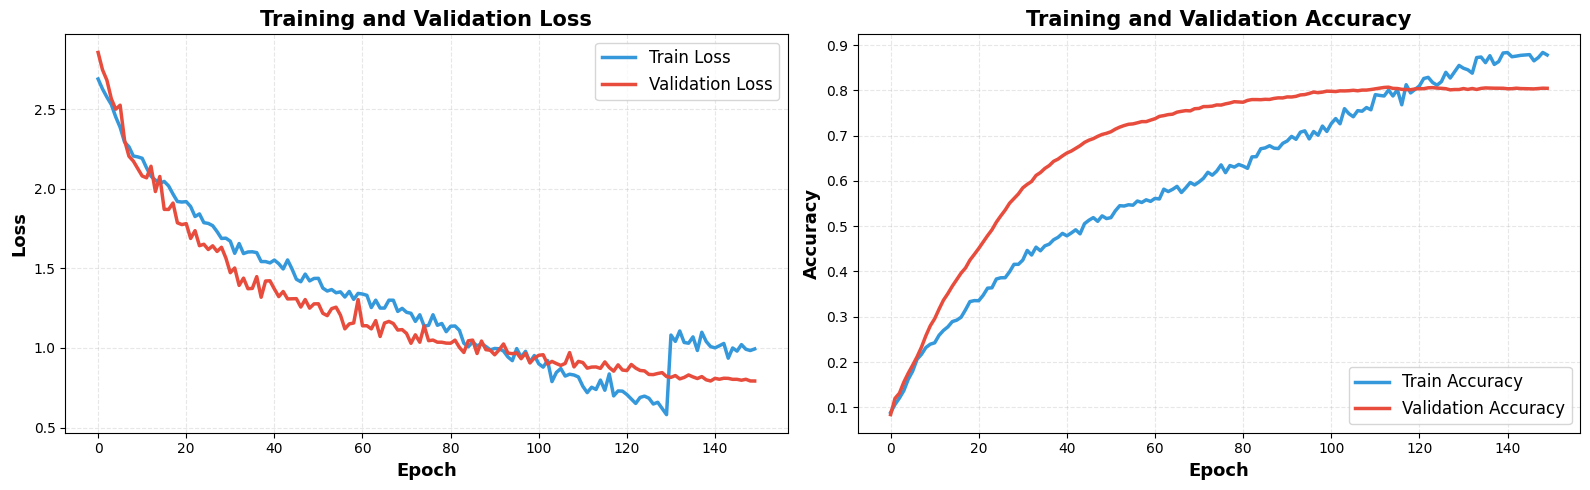

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predicting:   0%|          | 0/28 [00:00<?, ?it/s]/tmp/ipython-input-3246018787.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Predicting: 100%|██████████| 28/28 [00:04<00:00,  6.66it/s]


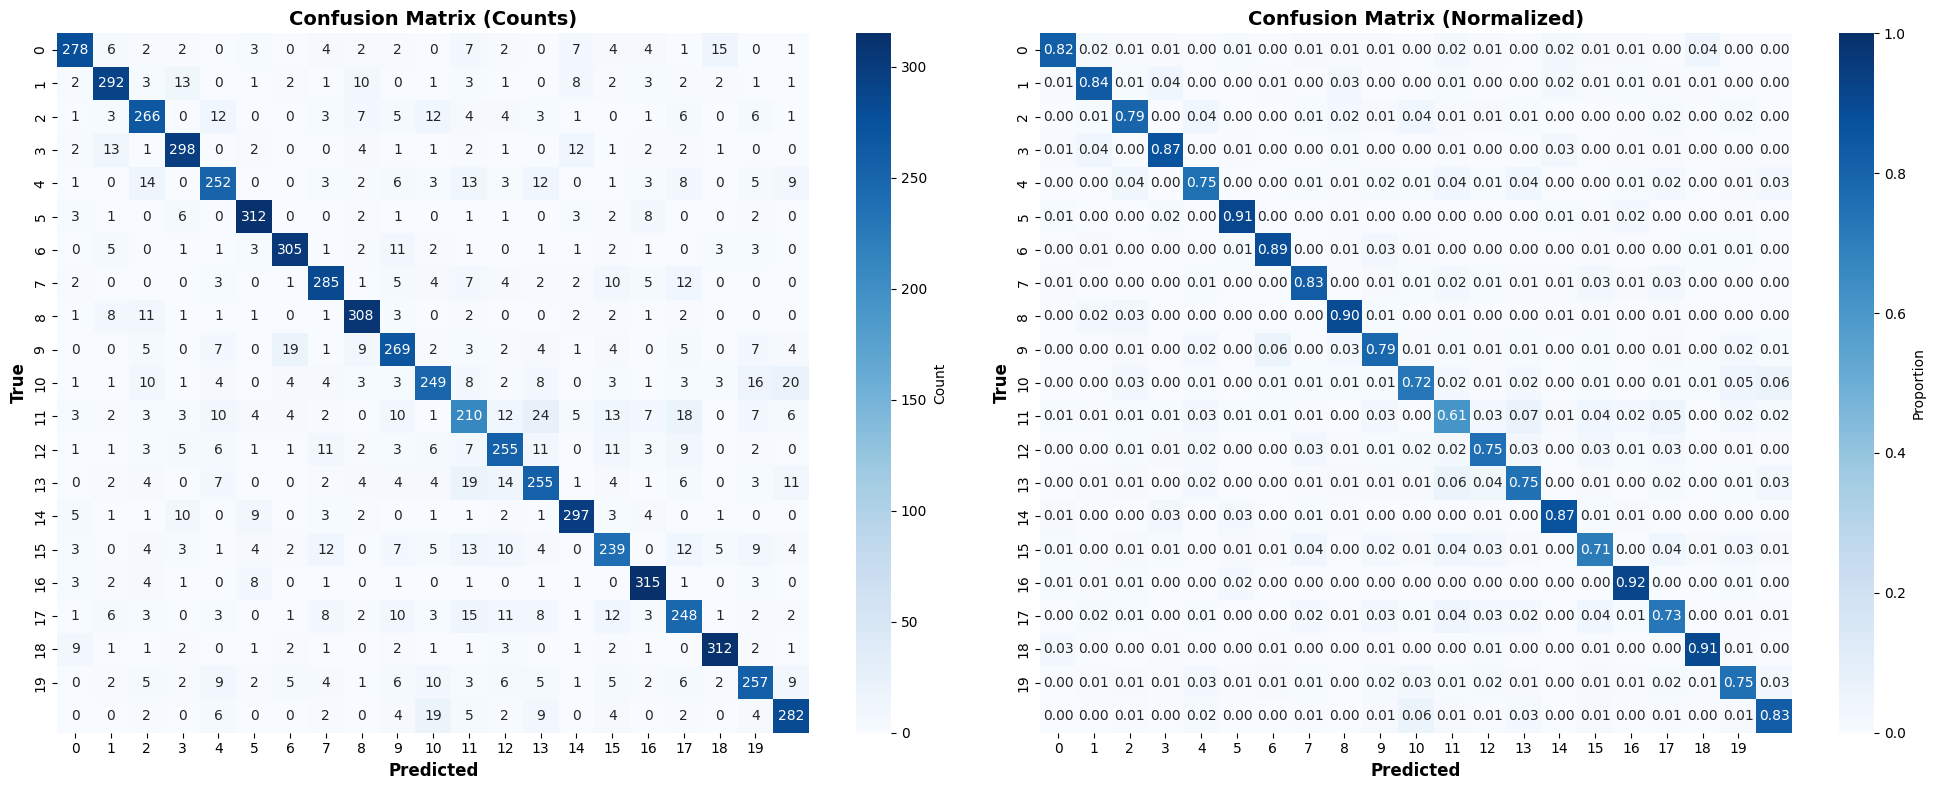

Class            Precision     Recall   F1-Score    Support
----------------------------------------------------------------------


ValueError: Unknown format code 's' for object of type 'int'

In [15]:
plot_history(history)
download_model(model)
class_name = np.arange(20)
y_pred, y_true, y_probs = get_all_predictions(model, val_loader, device)

plot_confusion_matrix(y_true, y_pred,class_name)

In [14]:

train_transform =  transforms.Compose([
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

f_epoch = 20
data_path = "./data/Kaggle02/"
model_path = '/content/drive/MyDrive/Kaggle2/best_model.pth'


state_dict = torch.load(model_path, map_location=device)

new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("_orig_mod.", "")
    new_state_dict[new_key] = v

model = ConvNeXtTiny()
model.load_state_dict(new_state_dict)
model.to(device)


train_dataset = MyDataset(data_path, train=True, transform=train_transform)

f_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.0005,
    momentum=0.9,
    weight_decay=5e-4,
    nesterov=True
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=f_epoch,eta_min=min_lr)
criterion = SoftTargetCrossEntropywithFL()

for epoch in range(20):
    model.train()

    total_loss = 0
    train_len = 0
    train_correct = 0

    # --- Training Phase ---
    pbar = tqdm(enumerate(f_train_loader), total=len(f_train_loader))
    for i, (images, labels) in pbar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()




100%|██████████| 288/288 [03:36<00:00,  1.33it/s]


In [ ]:
len(val_loader.dataset)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
correct = 0
total = len(val_loader.dataset)

model.load_state_dict(best_model_state)
eval_model = ema.module


with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = tta_predict(eval_model,images)
        _, predicted = torch.max(outputs, 1)

        correct += torch.sum((predicted == labels)).item()

print(f'Accuracy : {100 * correct / total} %')

Accuracy : 78.47619047619048 %


# Make SubmitFile

In [18]:
import pandas as pd

# 제출 파일 submission.csv 생성
outputs = {
    'Id': [],
    'Prediction': []
}

for images, id in tqdm(test_loader):
    model.eval()
    with torch.no_grad():
        output = tta_predict(ema.module,images.to(device))
        _, predicted = torch.max(output, 1)
        outputs['Prediction'] += predicted.tolist()
        outputs['Id'] += id

df = pd.DataFrame(outputs)

df.to_csv('submission.csv', index=False, columns=['Id', 'Prediction'])

  0%|          | 0/21 [00:01<?, ?it/s]


NameError: name 'ema' is not defined

In [20]:
# 제출파일 다운로드
from google.colab import files

file_path = "submission.csv"
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import pandas as pd

# 제출 파일 submission.csv 생성
outputs = {
    'Id': [],
    'Prediction': []
}

for images, id in tqdm(test_loader):
    model.eval()
    with torch.no_grad():
        output = tta_predict(model,images.to(device))
        _, predicted = torch.max(output, 1)
        outputs['Prediction'] += predicted.tolist()
        outputs['Id'] += id

df = pd.DataFrame(outputs)

df.to_csv('submission.csv', index=False, columns=['Id', 'Prediction'])

100%|██████████| 21/21 [00:11<00:00,  1.90it/s]


In [17]:
train_transform = transforms.Compose([
    v2.Resize((192,192),antialias=True),
    v2.RandomHorizontalFlip(0.5),
    v2.RandAugment(num_ops=2, magnitude=7

                   ),
    v2.ColorJitter(0.2, 0.2, 0.2, 0.1),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485,0.456,0.406),
                 std=(0.229,0.224,0.225)),
    v2.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
])


test_transform =  transforms.Compose([
    v2.Resize((192, 192), antialias=True),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
      ])
collate = v2.RandomChoice([
    v2.CutMix(num_classes=21,alpha=0.2),
    v2.MixUp(num_classes=21, alpha=0.2)
    ])

mixup_collate = MixupCollate(
    mixup_fn=collate,
    switch_epoch=mixup_collate_swiching_epoch
)

train_loader,val_loader = pre_process_data(transform = train_transform,batch_size=batch_size,is_train=True,train_val_split= val_train_split,collate_fn=mixup_collate)
test_loader = pre_process_data(transform = test_transform,batch_size=batch_size,is_train=False)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
